In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from experiments2.auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI

from tqdm import tqdm

imagespath = 'error_gradation_images'

C:\Users\User\PycharmProjects\GIEBN\venv\lib\site-packages\bamt\log.py:20: UserWarning: Reading log path location from config file failed. Default location will be used instead.
  warnings.warn(


In [2]:
data = pd.read_csv("../../datasets/narvikweather.csv")

n = data.shape[0]
target = "Friction_mean"
features = ['Tsurf_mean',
       'Water_mean', 'Speed_mean', 'totalSnow_cm',
        'uvIndex', 'cloudcover', 'humidity', 'precipMM',
       'pressure']
data = data[features+[target]]
n_features = len(features)
data.head(10)

,Tsurf_mean,Water_mean,Speed_mean,totalSnow_cm,uvIndex,cloudcover,humidity,precipMM,pressure,Friction_mean
0,1.810000,0.188333,4.166667,4.8,1,63,79,0.0,1030,0.290000
1,0.167647,0.829235,1.452941,19.6,1,93,89,0.6,1002,0.704706
2,-2.320000,0.000000,25.300000,33.7,1,100,94,1.2,1020,0.400000
3,3.230000,0.000000,27.900000,0.0,2,5,76,0.0,1013,0.790000
4,2.903333,0.295167,8.050000,0.0,2,68,78,0.0,1004,0.363333
5,2.180000,0.055000,29.800000,0.0,2,52,76,0.0,1013,0.330000
6,-6.010000,0.067667,16.333333,0.0,2,26,73,0.0,1018,0.356667
7,-10.480000,0.000000,38.900000,0.0,2,11,46,0.0,1016,0.320000
8,-10.400000,0.007000,30.500000,0.0,2,37,59,0.0,1023,0.790000
9,-1.257000,0.094000,2.000000,33.7,1,100,91,0.6,1019,0.358000


In [3]:
#sns.pairplot(data=data)

In [102]:
#model = GradientBoostingRegressor(n_estimators=30)
model = LinearRegression()
model.fit(data[features], data[target])

LinearRegression()

In [103]:
#model.coef_, model.intercept_

In [104]:
def discretize(data, variables, icat, icont, contdiscstrategy="kmeans"):
    transformers_data = dict()
    
    if icat is None: # в датасете только непрерывные фичи (и предиктор)
        pipeline = make_pipeline(
            KBinsDiscretizer(n_bins=3, encode="ordinal", random_state=42, strategy=contdiscstrategy), 
            FunctionTransformer(lambda x: x.astype("int")))
    elif icont is None: # в датасете только категориальные фичи (и предиктор)
        pipeline = make_pipeline(
            OrdinalEncoder(categories="auto"), 
            FunctionTransformer(lambda x: x.astype("int")))
    else:
        pipeline = make_pipeline(make_union(
        make_pipeline(FunctionTransformer(lambda x: x[:, icat]), OrdinalEncoder(categories="auto")),
        make_pipeline(FunctionTransformer(lambda x: x[:, icont]), KBinsDiscretizer(n_bins=3, encode="ordinal", random_state=42, strategy=contdiscstrategy))
    ),
        FunctionTransformer(lambda x: x.astype("int")))
    
    
    pipeline.fit(data.values)
    encoded_data = pd.DataFrame(pipeline.transform(data.values), columns=data.columns if icat is None or icont is None\
                                                                                        else data.columns[icat+icont])
    encoded_data = encoded_data[variables] # в общем случае пайплайн переставляет признаки, возвращаем их на их места здесь
    
    transformers_data["transformer"] = pipeline
    
    if icat is None:
        transformers_data["cont_features"]       = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cont_features_edges"] = pipeline.steps[0][1].bin_edges_
        
    elif icont is None:
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].categories_
        
    else:
        transformers_data["cont_features"]           = list(pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].get_feature_names_out())
        transformers_data["cont_features_edges"]     = pipeline.steps[0][1].named_transformers["pipeline-2"].steps[1][1].bin_edges_
        transformers_data["cat_features"]            = list(pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].get_feature_names_out())
        transformers_data["cat_features_categories"] = pipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_
    
    #kmeanspipeline.steps[0][1].named_transformers["pipeline-1"].steps[1][1].categories_[0]
    return encoded_data, transformers_data

#disc_data, pipeline_data = discretize(data, variables, icat=None, icont=[0, 1])


In [105]:
data_errors = data.copy(deep=True)
data_errors["sq_error"] = np.square(data[target]-model.predict(data[features]))
data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,Tsurf_mean,Water_mean,Speed_mean,totalSnow_cm,uvIndex,cloudcover,humidity,precipMM,pressure,sq_error
0,1.810000,0.188333,4.166667,4.8,1,63,79,0.0,1030,0.016625
1,0.167647,0.829235,1.452941,19.6,1,93,89,0.6,1002,0.050018
2,-2.320000,0.000000,25.300000,33.7,1,100,94,1.2,1020,0.001256
3,3.230000,0.000000,27.900000,0.0,2,5,76,0.0,1013,0.041570
4,2.903333,0.295167,8.050000,0.0,2,68,78,0.0,1004,0.044272


In [106]:
disc_data, pipeline_data = discretize(data_errors, features+["sq_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,Tsurf_mean,Water_mean,Speed_mean,totalSnow_cm,uvIndex,cloudcover,humidity,precipMM,pressure,sq_error
0,2,0,0,0,0,1,1,0,2,0
1,2,1,0,1,0,2,2,0,0,1
2,1,0,1,2,0,2,2,1,2,0
3,2,0,1,0,1,0,1,0,1,1
4,2,0,0,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
995,2,0,0,0,0,1,1,0,2,0
996,1,0,2,0,1,2,1,0,1,0
997,2,0,2,0,0,2,1,0,0,0
998,0,0,1,0,1,0,1,0,1,0


In [107]:
current_error = data_errors["sq_error"].sum()/n
current_error

0.025761985402785938

In [108]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore

def collect_all_cpds(bn_info, distributions, n_states_map):
    cpds = list()
    for index, row in bn_info.iterrows():
        feat = row["name"].name
        if len(row["parents"]) == 0:
            # cpd is just a pd
            cpd = TabularCPD(feat, n_states_map[feat], [[e] for e in distributions[feat]["cprob"]])
            cpds.append(cpd)
        else:
            cpd_list = [probs for probs in distributions[feat]["cprob"].values()]
            #cpd_list = [probs for i, probs in distributions[feat]["cprob"].items() if i[0]!="["]
            #print(cpd_list)
            nrows = len(cpd_list)
            ncols = len(cpd_list[0])
            cpd_list = [[cpd_list[i][j] for i in range(nrows)] for j in range(ncols)]
            #print(feat, row["parents"])
            #print(cpd_list)
            cpd = TabularCPD(feat, n_states_map[feat], cpd_list, evidence=row["parents"], evidence_card=[n_states_map[p] for p in row["parents"]])
            cpds.append(cpd)
    return cpds



In [109]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'Tsurf_mean': 3,
 'Water_mean': 3,
 'Speed_mean': 3,
 'totalSnow_cm': 3,
 'uvIndex': 2,
 'cloudcover': 3,
 'humidity': 3,
 'precipMM': 3,
 'pressure': 3,
 'sq_error': 3}

In [110]:
from bamt.networks.base import STORAGE

In [111]:
#STORAGE = "C://Users/Дима/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/bn_structures"

bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("sq_error", x) for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)

In [112]:
bn.add_edges(disc_data, scoring_function=("K2", K2Score), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [113]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,precipMM,Discrete,disc,[],[]
1,humidity,Discrete,disc,[precipMM],[disc]
2,cloudcover,Discrete,disc,[humidity],[disc]
3,totalSnow_cm,Discrete,disc,"[humidity, precipMM]","[disc, disc]"
4,pressure,Discrete,disc,"[totalSnow_cm, cloudcover, humidity, precipMM]","[disc, disc, disc, disc]"
5,uvIndex,Discrete,disc,"[humidity, pressure]","[disc, disc]"
6,Tsurf_mean,Discrete,disc,"[totalSnow_cm, uvIndex, cloudcover, humidity, ...","[disc, disc, disc, disc, disc]"
7,Water_mean,Discrete,disc,"[Tsurf_mean, precipMM]","[disc, disc]"
8,Speed_mean,Discrete,disc,[Water_mean],[disc]
9,sq_error,Discrete,disc,"[Tsurf_mean, Speed_mean, pressure]","[disc, disc, disc]"


In [114]:
data["uvIndex"].value_counts()

1    531
2    469
Name: uvIndex, dtype: int64

In [82]:
bn.nodes

[precipMM,
 humidity,
 cloudcover,
 totalSnow_cm,
 pressure,
 uvIndex,
 Tsurf_mean,
 sq_error,
 Water_mean,
 Speed_mean]

In [115]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [116]:
bn.distributions

{'precipMM': {'cprob': [0.931, 0.059, 0.01], 'vals': ['0', '1', '2']},
 'humidity': {'cprob': {"['0']": [0.11493018259935553,
    0.6702470461868958,
    0.21482277121374865],
   "['1']": [0.0, 0.0, 1.0],
   "['2']": [0.0, 0.0, 1.0]},
  'vals': ['0', '1', '2']},
 'cloudcover': {'cprob': {"['1']": [0.3541666666666667,
    0.358974358974359,
    0.28685897435897434],
   "['2']": [0.0, 0.07063197026022305, 0.929368029739777],
   "['0']": [0.6915887850467289, 0.1308411214953271, 0.17757009345794392]},
  'vals': ['0', '1', '2']},
 'totalSnow_cm': {'cprob': {"['1', '0']": [0.9903846153846154,
    0.009615384615384616,
    0.0],
   "['1', '1']": [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
   "['1', '2']": [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
   "['2', '0']": [0.765, 0.195, 0.04],
   "['2', '1']": [0.4067796610169492, 0.3389830508474576, 0.2542372881355932],
   "['2', '2']": [0.8, 0.0, 0.2],
   "['0', '0']": [1.0, 0.0, 0.0],
   "['0', '1']": [0.333333

In [117]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

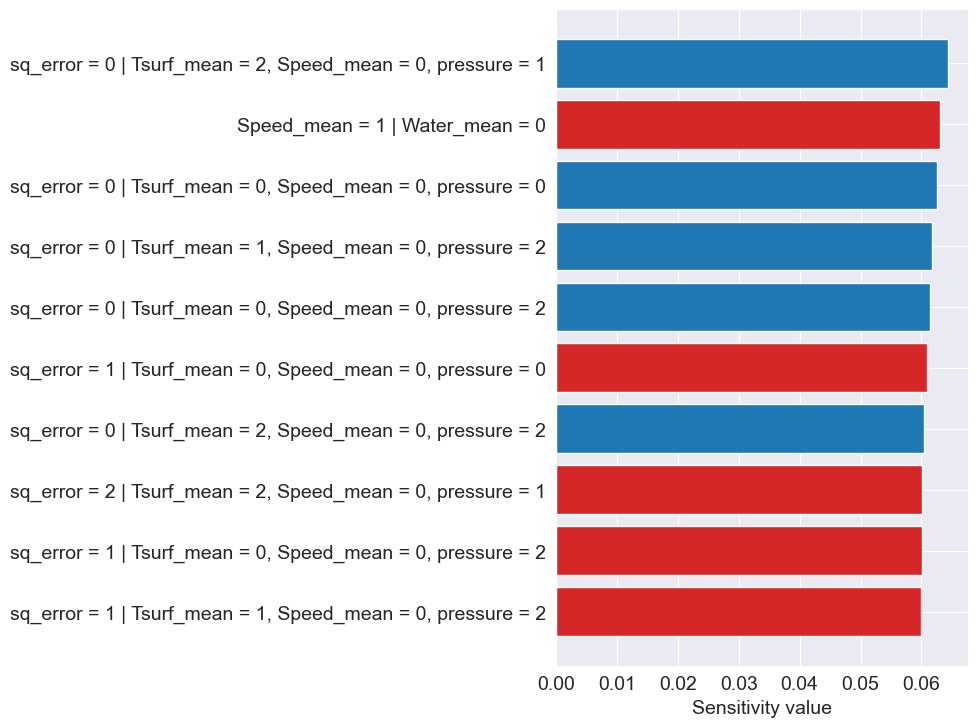

In [118]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'sq_error': 0}, nbars=10)

<Figure size 640x480 with 0 Axes>

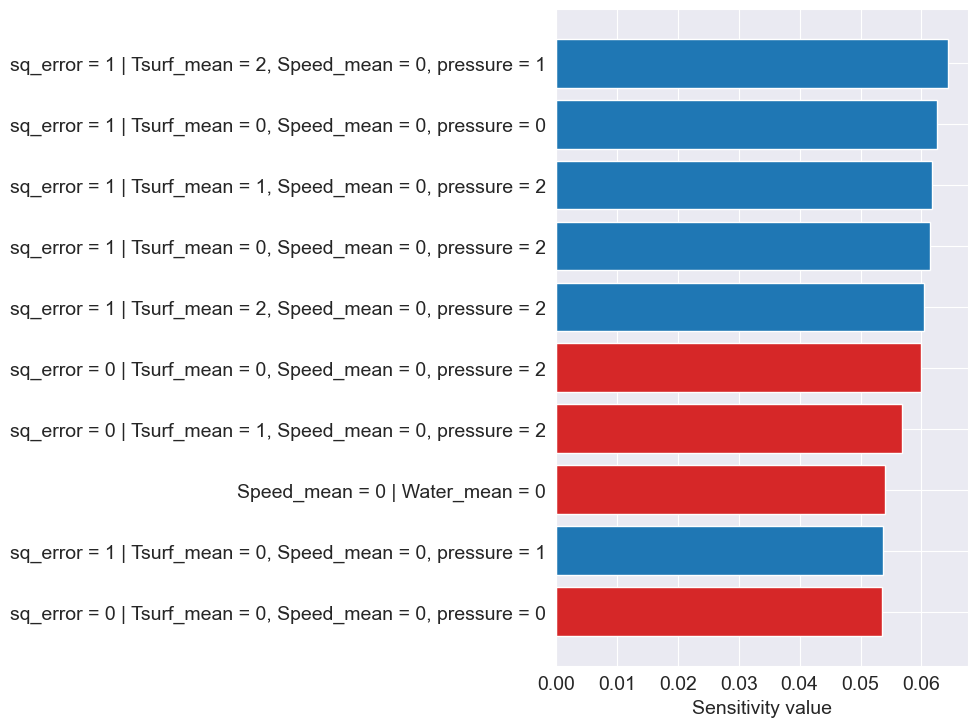

In [119]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'sq_error': 1}, nbars=10)

<Figure size 640x480 with 0 Axes>

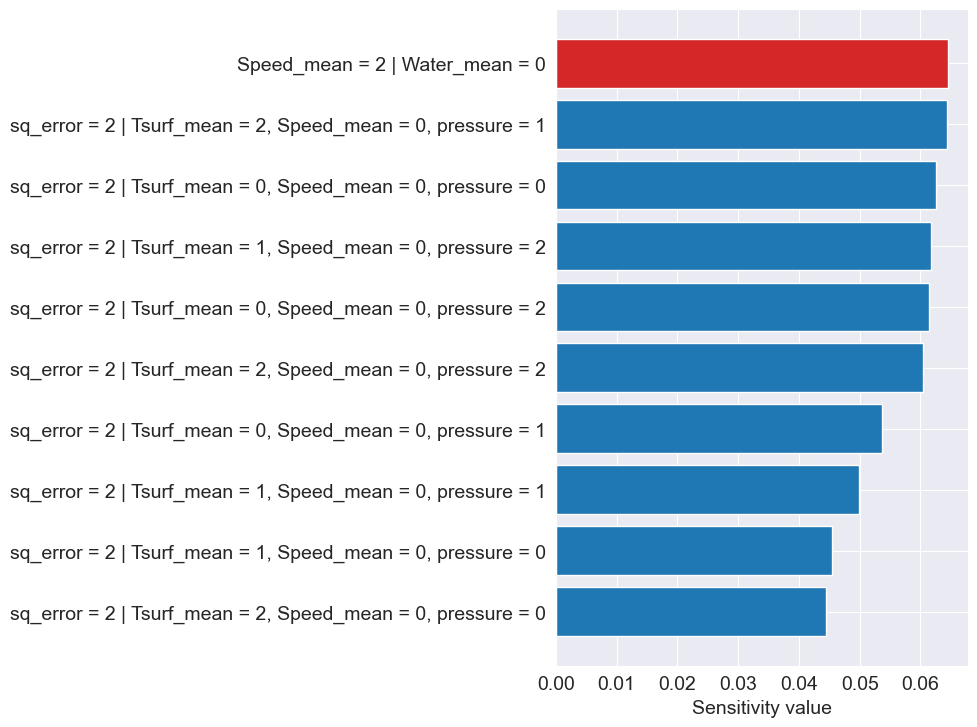

In [120]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'sq_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии высокого УФ-индекса (здесь 1 маскимальный) и среднего давления

In [96]:
((disc_data["uvIndex"]==1)|(disc_data["pressure"]==1)).sum()

639

In [97]:
(disc_data["pressure"]==1).sum()

483

In [98]:
current_error

0.025761985402785938

In [28]:
new_data = data[~((disc_data["uvIndex"]==1)&(disc_data["pressure"]==1))]
new_data

,Tsurf_mean,Water_mean,Speed_mean,totalSnow_cm,uvIndex,cloudcover,humidity,precipMM,pressure,Friction_mean
0,1.810000,0.188333,4.166667,4.8,1,63,79,0.0,1030,0.290000
1,0.167647,0.829235,1.452941,19.6,1,93,89,0.6,1002,0.704706
2,-2.320000,0.000000,25.300000,33.7,1,100,94,1.2,1020,0.400000
4,2.903333,0.295167,8.050000,0.0,2,68,78,0.0,1004,0.363333
6,-6.010000,0.067667,16.333333,0.0,2,26,73,0.0,1018,0.356667
...,...,...,...,...,...,...,...,...,...,...
993,-5.688889,0.026111,5.866667,0.0,2,6,67,0.0,1018,0.407778
994,-5.435000,0.000000,12.650000,7.9,1,87,93,1.0,1013,0.370000
995,0.260000,0.095769,6.415385,0.0,1,50,72,0.0,1018,0.373077
997,-1.290000,0.262000,65.200000,0.0,1,95,74,0.0,998,0.680000


In [29]:
from copy import copy

In [89]:
model1 = copy(model)
model1.fit(new_data[features], new_data[target])

GradientBoostingRegressor(n_estimators=30)

In [90]:
np.square(model1.predict(new_data[features])-new_data[target]).mean()

0.010671302436437376

# K2Score boosting: рекомендовано удалить uvindex == Low
# regression: [Tsurf_mean, Speed_mean, pressure] = [2, 0, 1]

In [32]:
from sklearn.metrics import mean_squared_error as MSE

In [126]:
mask = False
for feat, cat in zip(dfeat, dcat):
    mask = mask | (disc_data[feat]==cat)

In [127]:
mask.sum()

891

In [128]:
#dfeat = ["uvIndex"]
#dcat = [0]
dfeat = ["Tsurf_mean", "Speed_mean", "pressure"]
dcat = [2, 0, 1]

dropping_category_minmax = data[disc_data[dfeat]==1][dfeat].min(), data[disc_data[dfeat]==1][dfeat].max()

def bootstrap_sampling(dfeat, dcat, trials=1000):
    
    diffs = list()
    mses_before, mses_after = list(), list()
    
    #пробуем побутсрапировать выборку, чтобы оценить значимость различий в ошибках регрессии
    for i in tqdm(range(trials)):
        bsample = data.iloc[np.random.randint(n, size=n)]
        
        bsample_disc = pd.DataFrame(pipeline_data["transformer"].transform(bsample), columns=features+[target])
        
        #mask = True
        mask = False
        for feat, cat in zip(dfeat, dcat):
            mask = mask | (bsample_disc[feat]==cat)
        
        new_bsample = bsample[~mask]
        
        X1, y1 = bsample[features], bsample[target]
        X2, y2 = new_bsample[features], new_bsample[target]
        model1, model2 = copy(model), copy(model)
        
        model1.fit(X1, y1), model2.fit(X2, y2)
        y1_pred, y2_pred = model1.predict(X1), model2.predict(X2)
        mses_before.append(MSE(y1, y1_pred))
        mses_after.append(MSE(y2, y2_pred))
        diffs.append(MSE(y1, y1_pred) - MSE(y2, y2_pred))
        
    return mses_before, mses_after, diffs

In [141]:
np.random.seed(42)
mses_before, mses_after, diffs = bootstrap_sampling(dfeat, dcat, trials=500)

100%|██████████| 500/500 [00:04<00:00, 105.17it/s]


In [137]:
diffs

[0.0038272862699673046,
 0.004530052114649685,
 0.003207831234753638,
 0.0057325181046225665,
 -0.0018077359461997483,
 -0.0013773031172397525,
 0.0021914886971294914,
 0.005640460257162288,
 0.0020415168788124743,
 0.0006163030542936689,
 -0.0006771260704462531,
 0.002634340974692815,
 -0.0016198854431897988,
 -0.0004899334922909455,
 8.110854333514064e-05,
 0.0010170571841556925,
 0.005946205529750552,
 0.003573707778732213,
 -0.0008947618626791998,
 0.0023158447803407166,
 0.0027689251278567688,
 0.0009088677363910183,
 -0.0007689559677965807,
 0.004246238286772272,
 0.0008443704794475586,
 -0.0012560818550654378,
 0.0012845967670273122,
 -0.0020124397623712646,
 9.436133623508605e-05,
 0.005242395229478478,
 -0.0014875024061883103,
 0.0017769042070336083,
 0.0006976687755862118,
 -0.0002460178497122219,
 0.002068394460380721,
 0.0026013230095971313,
 0.0029587926781935933,
 0.0033134227369257287,
 0.0002455754496680333,
 0.004526973823570028,
 -0.0024378375455401252,
 -0.0011628021

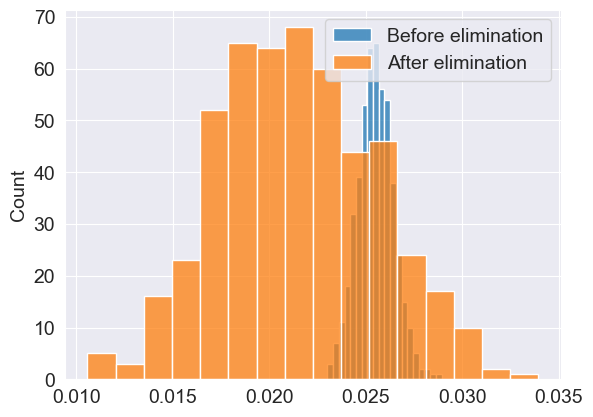

In [142]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

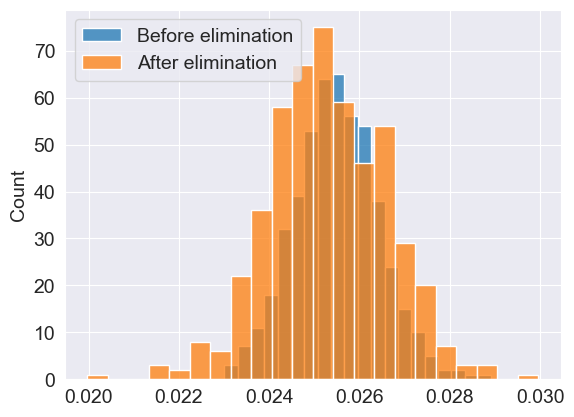

In [108]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

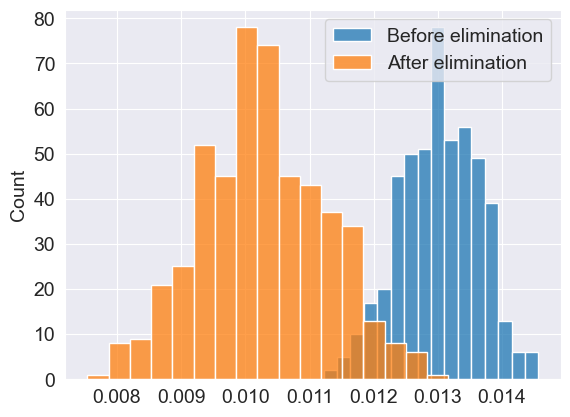

In [75]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [37]:
from scipy.stats import ttest_rel

In [143]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=22.87037872459797, pvalue=1.0224723133671965e-79, df=499)

In [34]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=6.188110428072777, pvalue=1.3809858468302787e-08)

In [144]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,Tsurf_mean_0,Tsurf_mean_1,Tsurf_mean_2,Water_mean_0,Water_mean_1,Water_mean_2,Speed_mean_0,Speed_mean_1,Speed_mean_2,totalSnow_cm_0,...,humidity_2,precipMM_0,precipMM_1,precipMM_2,pressure_0,pressure_1,pressure_2,sq_error_0,sq_error_1,sq_error_2
0,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1,0,0,1,0,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,1,0,0
3,0,0,1,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
996,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0
997,0,0,1,1,0,0,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
998,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [145]:
from itertools import product

In [151]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "sq_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "sq_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", K2Score), params={"bl_add": blacklist})

2023-09-27 23:53:50,627 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,628 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,629 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,629 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,630 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,631 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,633 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,636 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,638 | ERROR    | GraphUtils.py-nodes_types-0033 | Unsupported data type. Dtype: uint8
2023-09-27 23:53:50,639 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [152]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,totalSnow_cm_0,Discrete,disc,[],[]
1,precipMM_2,Discrete,disc,[],[]
2,pressure_2,Discrete,disc,[precipMM_2],[disc]
3,humidity_2,Discrete,disc,"[totalSnow_cm_0, precipMM_2, pressure_2]","[disc, disc, disc]"
4,cloudcover_0,Discrete,disc,"[humidity_2, pressure_2]","[disc, disc]"
5,totalSnow_cm_1,Discrete,disc,"[humidity_2, precipMM_2, pressure_2]","[disc, disc, disc]"
6,Water_mean_2,Discrete,disc,[humidity_2],[disc]
7,precipMM_0,Discrete,disc,"[totalSnow_cm_0, totalSnow_cm_1, humidity_2, p...","[disc, disc, disc, disc]"
8,totalSnow_cm_2,Discrete,disc,"[precipMM_0, pressure_2]","[disc, disc]"
9,Tsurf_mean_2,Discrete,disc,"[totalSnow_cm_1, cloudcover_0, precipMM_0, pre...","[disc, disc, disc, disc]"


# k2score boosting: рекомендовано удалить humidity == mid
# regression : [Tsurf_mean_0, pressure_2]

In [153]:
dfeat = ["Tsurf_mean", "humidity", "precipMM", "pressure"]
dcat = [0, 0, 2, 2]
np.random.seed(42)
mses_before, mses_after, diffs = bootstrap_sampling(dfeat, dcat, trials=500)

100%|██████████| 500/500 [00:05<00:00, 91.57it/s]


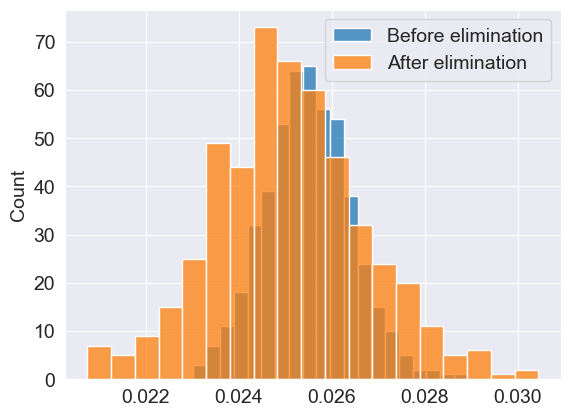

In [154]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [155]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=7.107030362824421, pvalue=4.120878496098245e-12, df=499)

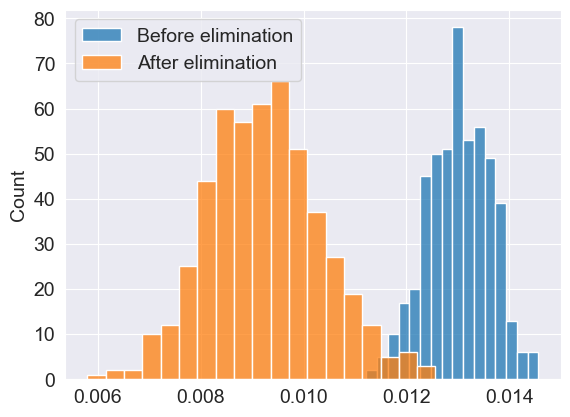

In [81]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [37]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=3.5513027688261474, pvalue=0.0005886470203057337)

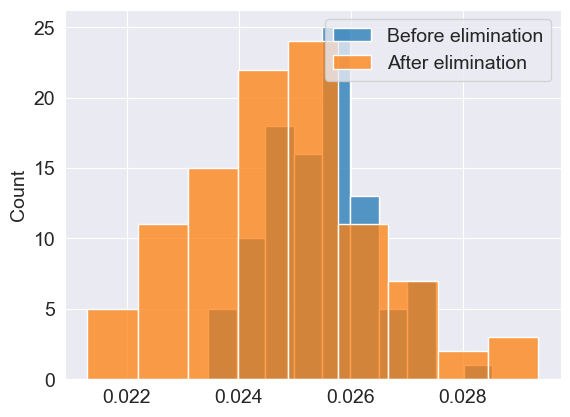

In [39]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [40]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=4.5674716964522615, pvalue=1.4238634976675129e-05)

In [41]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [42]:
disc_data_onehot

,Tsurf_mean_0,Tsurf_mean_1,Tsurf_mean_2,Water_mean_0,Water_mean_1,Water_mean_2,Speed_mean_0,Speed_mean_1,Speed_mean_2,totalSnow_cm_0,...,humidity_2,precipMM_0,precipMM_1,precipMM_2,pressure_0,pressure_1,pressure_2,sq_error_0,sq_error_1,sq_error_2
0,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1,0,0,1,0,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,1,0,0
3,0,0,1,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
996,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0
997,0,0,1,1,0,0,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
998,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [43]:
gbn = DiscreteBNGI(imagespath)

In [44]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

KeyError: 'Tsurf_mean_0'

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")